In [181]:
from FDFD.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from FDFD.linalg import solver_direct

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-7                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [183]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [184]:
# set source 
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1

In [185]:
# Define objective function and partial derivative
Jregion = np.zeros(eps_r.shape)
Jregion[45:50, 60] = 1
J = lambda Ez: np.sum(np.square(np.abs(Ez*Jregion)))
dJdE = lambda Ez: np.conj(Ez)*Jregion
# Define permittivity change region
deps_region = np.zeros(eps_r.shape)
deps_region[45:50, 40:50] = 1;

In [186]:
# Compute numerical gradient
deps = 1e-8
simulation.reset_eps(eps_r + deps*deps_region)
(Hxf,Hyf,Ezf) = simulation.solve_fields(b)
simulation.reset_eps(eps_r - deps*deps_region)
(Hxb,Hyb,Ezb) = simulation.solve_fields(b)
grad_num = (J(Ezf) - J(Ezb))/2/deps
print(grad_num)

-0.0042460094468177445


In [187]:
# Compute adjoint gradient

# Solve fields and compute adjoint source
simulation.reset_eps(eps_r)
(Hx,Hy,Ez) = simulation.solve_fields(b)
b_aj = -dJdE(Ez)

# Compute dAdeps
A = simulation.A
Nbig = simulation.Nx*simulation.Ny
dAdeps = simulation.dAdeps*sp.spdiags(deps_region.reshape(-1,), 0, Nbig, Nbig, format='csc')

# Try first using the same matrix A for the adjoint
(Hx_aj,Hy_aj,Ez_aj1) = simulation.solve_fields(b_aj)
grad_aj1 = 2*np.real((Ez_aj1.reshape((1,-1)).dot(dAdeps.dot(Ez.reshape(-1)))).sum())
print(grad_aj1)
print((grad_aj1 - grad_num)**2)

# Then try instead using A.T for the adjoint
Ez_aj2 = solver_direct(A.T, b_aj)
grad_aj2 = 2*np.real(Ez_aj2.dot(dAdeps.dot(Ez.reshape(-1))).sum())
print(grad_aj2)
print((grad_aj2 - grad_num)**2)

-0.004246010869423333
2.023806661528309e-18
-0.00424601086942333
2.0238066516569997e-18


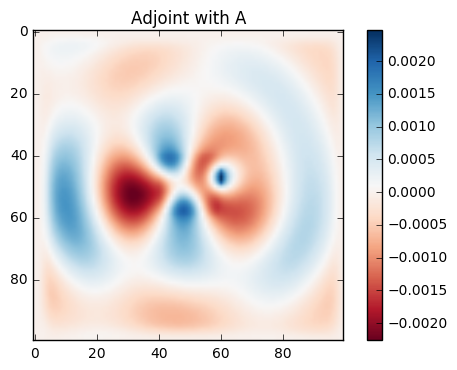

In [188]:
# plot
plt.imshow(np.real(Ez_aj1.reshape(simulation.Nx, simulation.Ny)), cmap='RdBu')
plt.colorbar()
plt.title('Adjoint with A')
plt.show()

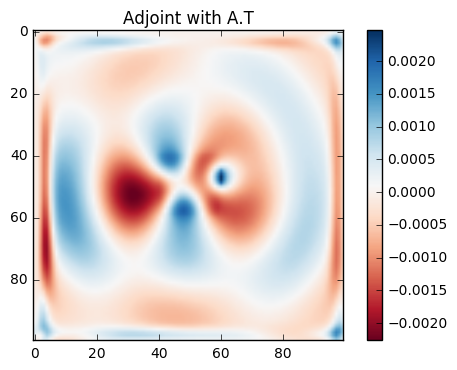

In [189]:
# plot
plt.imshow(np.real(Ez_aj2.reshape(simulation.Nx, simulation.Ny)), cmap='RdBu')
plt.colorbar()
plt.title('Adjoint with A.T')
plt.show()

In [190]:
# The two adjoint fields don't match in the PMLs but they match in the simulation region
# The gradient computed in both ways thus matches even though technically A != A.T:
print(sp.linalg.norm(A - A.T))

479.7254840062094


In [191]:
# Now let's try Hz polarization
pol = 'Hz'  
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [192]:
# Define objective function and partial derivative
Jregion = np.zeros(eps_r.shape)
Jregion[45:50, 50] = 1
J = lambda Hz: np.sum(np.square(np.abs(Hz*Jregion)))
dJdE = lambda Hz: np.conj(Hz)*Jregion
# Define permittivity change region
deps_region = np.zeros(eps_r.shape)
deps_region[45:50, 40:50] = 1;

In [193]:
# Compute numerical gradient
deps = 1e-8
simulation.reset_eps(eps_r + deps*deps_region)
(Exf,Eyf,Hzf) = simulation.solve_fields(b)
simulation.reset_eps(eps_r - deps*deps_region)
(Exb,Eyb,Hzb) = simulation.solve_fields(b)
grad_num = (J(Hzf) - J(Hzb))/2/deps
print(grad_num)

0.00224441576435197


In [194]:
# Compute adjoint gradient

# Solve fields and compute adjoint source
simulation.reset_eps(eps_r)
(Ex, Ey, Hz) = simulation.solve_fields(b)
b_aj = -dJdE(Hz)

# Compute dAdeps
A = simulation.A
Nbig = simulation.Nx*simulation.Ny

# Since eps_r enters both eps_x and eps_y, we sum those two contributions
dAdepsx = simulation.dAdeps['dAdepsx']
dAdepsy = simulation.dAdeps['dAdepsy']
dAdeps = (dAdepsx + dAdepsy)*sp.spdiags(deps_region.reshape(-1,), 0, Nbig, Nbig, format='csc')

# Try first using the same matrix A for the adjoint
(Ex_aj,Ey_aj,Hz_aj1) = simulation.solve_fields(b_aj)
grad_aj1 = 2*np.real((Hz_aj1.reshape((1,-1)).dot(dAdeps.dot(Hz.reshape(-1)))).sum())
print(grad_aj1)
print((grad_aj1 - grad_num)**2)

# I checked that the adjoint computed with A.T is the same as before.
# The gradients don't match however... TBD why.

0.006311838268262315
1.65439258253163e-05
